In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi
from exact_sync.v1.api.products_api import ProductsApi
from exact_sync.v1.api.teams_api import TeamsApi

from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Image, Annotation, AnnotationMediaFile
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

In [9]:
configuration = Configuration()
configuration.username = 'marzahl'
configuration.password = '****'
configuration.host =  "https://exact.cs.fau.de/"

image_set_ids = [14]

In [10]:
client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)
product_api = ProductsApi(client)

In [11]:
images = {}
annotation_types = {}

for image_set in image_set_ids:
    for image in images_api.list_images(pagination=False, image_set=image_set, image_type=0).results:
        images[image.id] = image
    for product in product_api.list_products(imagesets=image_set).results:
        for anno_type in annotation_types_api.list_annotation_types(product=product.id).results:
            annotation_types[anno_type.id] = anno_type

In [16]:
rows = []

for image_id, image in tqdm(images.items()):
    for annotation_type_id, annotation_type in annotation_types.items():
        
        for anno in annotations_api.list_annotations(annotation_type=annotation_type.id, pagination=False, image=image_id,
                                                     fields="id,unique_identifier,annotation_type,vector,user,deleted").results:

            if anno.vector is not None: 
                rows.append([anno.id, image.id, image.name, image.image_set, annotation_type.name, anno.vector, anno.unique_identifier, anno.user, anno.deleted, anno.last_editor])

    df = pd.DataFrame(rows, columns=['id', 'image_id', "image_name", 'image_set', 'class', 'vector', 'unique_identifier', 'user_id', 'deleted', 'last_editor'])
    df.to_pickle("Asthma_Annotations.pkl")

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:11<00:00, 71.86s/it]


In [17]:
df.head()

,id,image_id,image_name,image_set,class,vector,unique_identifier,user_id,deleted,last_editor
0,172441,221,BAL 1 Spray 2.svs,14,Makrophagen,"{'x1': 13612, 'x2': 13666, 'y1': 12371, 'y2': ...",a268b46f-e13f-480e-b96d-c7900790ad5f,10,False,None
1,172442,221,BAL 1 Spray 2.svs,14,Makrophagen,"{'x1': 13562, 'x2': 13618, 'y1': 12437, 'y2': ...",e8d67efd-0baf-4f78-ad73-b8f77422b826,10,False,None
2,172443,221,BAL 1 Spray 2.svs,14,Makrophagen,"{'x1': 13482, 'x2': 13546, 'y1': 12458, 'y2': ...",55aa3d51-7f30-43a0-83ef-d9acc74d9a21,10,False,None
3,172444,221,BAL 1 Spray 2.svs,14,Makrophagen,"{'x1': 13471, 'x2': 13533, 'y1': 12281, 'y2': ...",8f259e8f-119b-44de-8a90-2c53e7ee0e60,10,False,None
4,172446,221,BAL 1 Spray 2.svs,14,Makrophagen,"{'x1': 13591, 'x2': 13673, 'y1': 12204, 'y2': ...",052b3f5a-f6f6-4b0d-a134-9f4797601dc4,10,False,None


In [40]:
df["image_name"].unique()

array(['BAL 1 Spray 2.svs', 'BAL Promyk Spray 4.svs',
       'BAL AIA Blickfang Luft.svs', 'BAL Booker Spray 3.svs',
       'BAL Bubi Spray 1.svs', 'BAL cent blue Luft 2.svs'], dtype=object)

In [41]:
df["class"].unique()

array(['Makrophagen', 'Lymohozyten', 'Neutrophile', 'Mastzellen',
       'Eosinophile', 'Mehrkernige', 'Erythrozyt', 'Weitere', 'Schrott',
       'ROI'], dtype=object)

In [25]:
data = []

for label in df["class"].unique():
    
    num_label = df[df["class"] == label].shape[0]
    
    data.append([num_label])
    
dfStat = pd.DataFrame(data, columns=[ "count"], index=df["class"].unique())
dfStat

,count
Makrophagen,26501
Lymohozyten,46398
Neutrophile,12557
Mastzellen,1535
Eosinophile,108
Mehrkernige,311
Erythrozyt,340
Weitere,130
Schrott,4691
ROI,48


In [29]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

<AxesSubplot:ylabel='count'>

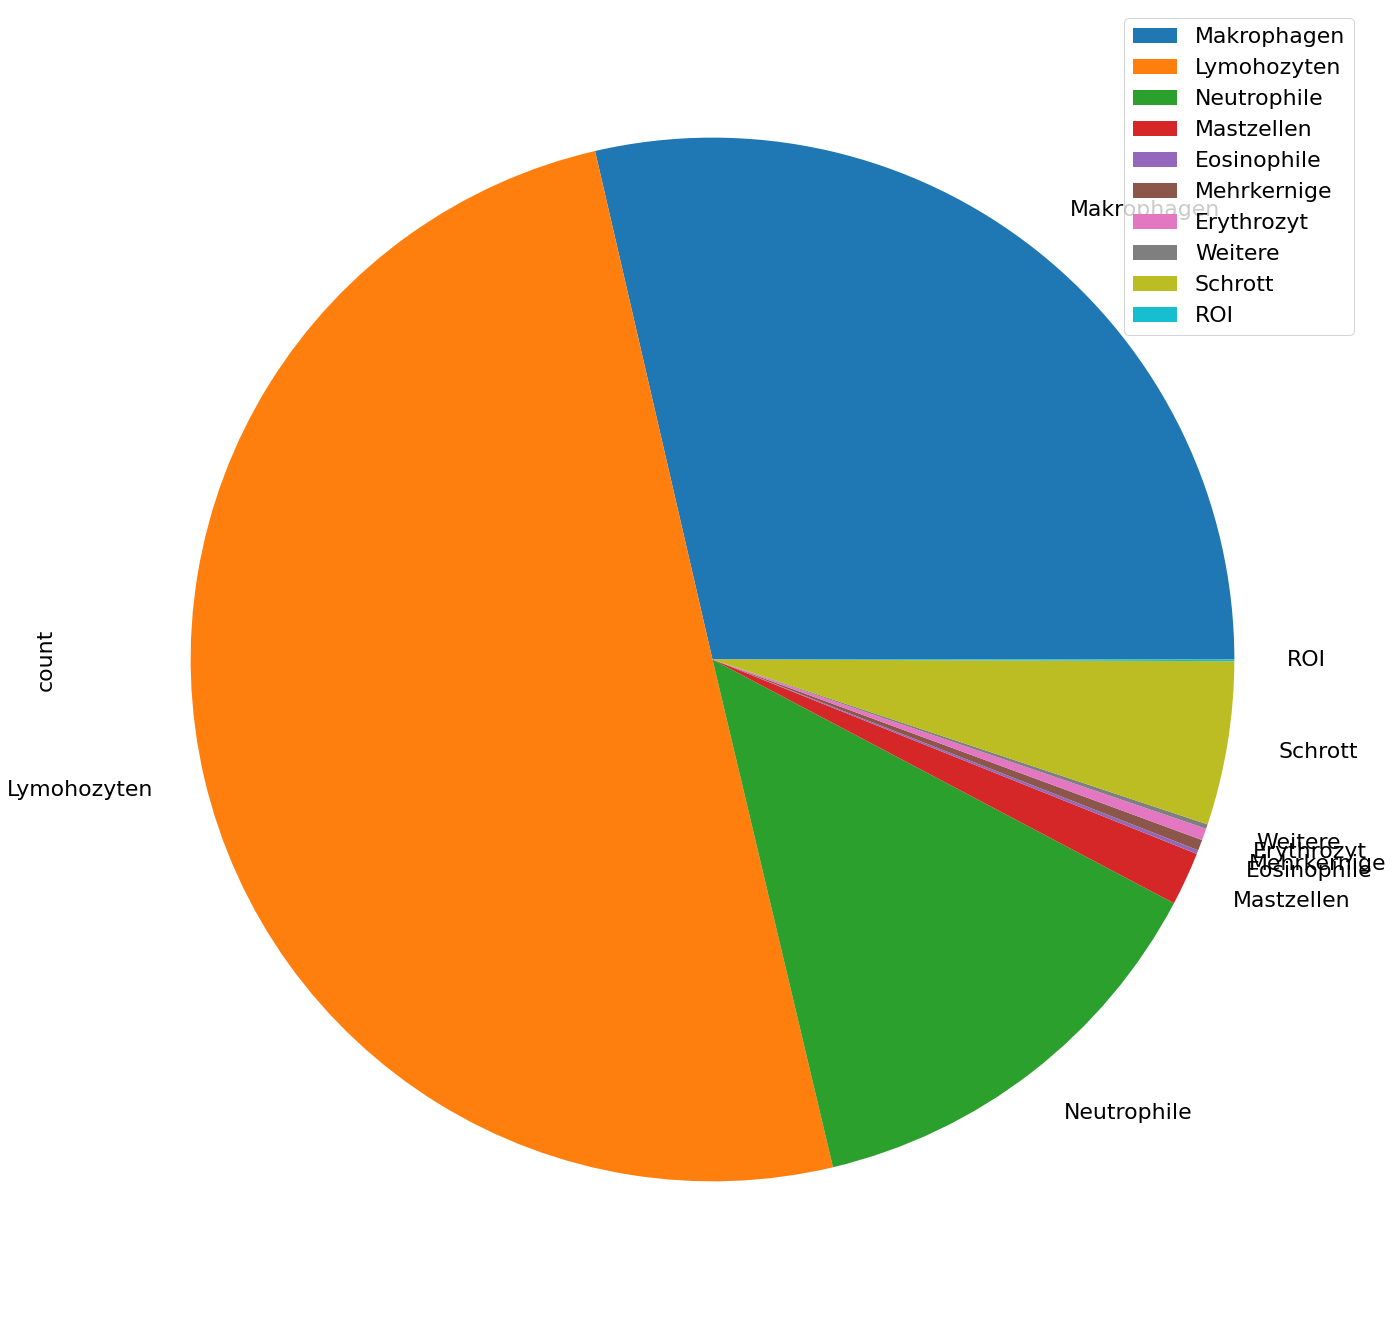

In [39]:
dfStat.plot.pie(y="count", figsize=(24, 24),)

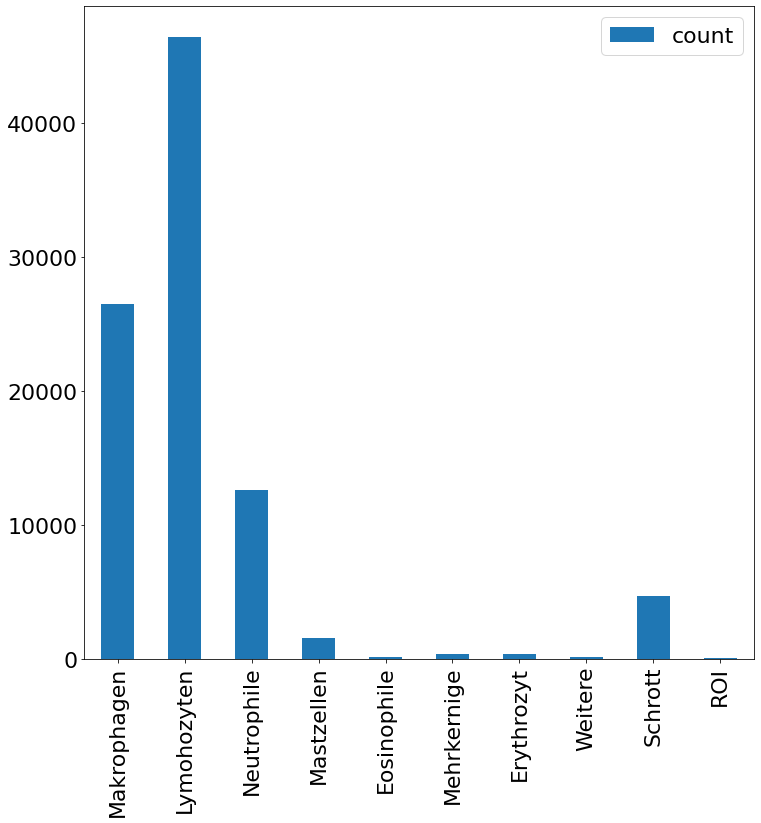

In [37]:
axes = dfStat.plot.bar(y="count", figsize=(12, 12))
#axes.legend(loc=10)  